#### Note - adapted from hls4ml tutorial part 3
#### https://github.com/fastmachinelearning/hls4ml-tutorial/

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os

os.environ['XILINX_VIVADO'] = '/vol/cc/opt/Xilinx/2020.1/Vivado/2020.1'
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

2025-06-04 14:58:47.759978: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
X_train_val = np.load('X_train_val.npy')
X_test = np.load('X_test.npy')
y_train_val = np.load('y_train_val.npy')
y_test = np.load('y_test.npy')
classes = np.load('classes.npy', allow_pickle=True)

## Now construct a model
We'll use the same architecture as in part 1: 3 hidden layers with 64, then 32, then 32 neurons. Each layer will use `relu` activation.
Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks_pre import all_callbacks

In [4]:
model = Sequential()
model.add(Dense(64, input_shape=(16,), name='fc1', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu1'))
model.add(Dense(32, name='fc2', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu2'))
model.add(Dense(32, name='fc3', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu3'))
model.add(Dense(5, name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='softmax', name='softmax'))

## Train sparse
This time we'll use the Tensorflow model optimization sparsity to train a sparse model (forcing many weights to '0'). In this instance, the target sparsity is 75%

In [5]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(0.75, begin_step=2000, frequency=100)}
model = prune.prune_low_magnitude(model, **pruning_params)

## Train the model
We'll use the same settings as the model for part 1: Adam optimizer with categorical crossentropy loss.
The callbacks will decay the learning rate and save the model into a directory 'pruned_jet_tagging_model'
The model isn't very complex, so this should just take a few minutes even on the CPU.
If you've restarted the notebook kernel after training once, set `train = False` to load the trained model rather than training again.

In [6]:
train = False
if train:
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir='pruned_jet_tagging_model',
    )
    callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    model.fit(
        X_train_val,
        y_train_val,
        batch_size=1024,
        epochs=30,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )
    # Save the model again but with the pruning 'stripped' to use the regular layer types
    model = strip_pruning(model)
    model.save('pruned_jet_tagging_model/KERAS_check_best_model.h5')
else:
    from tensorflow.keras.models import load_model

    model = load_model('pruned_jet_tagging_model/KERAS_check_best_model.h5')

## Check sparsity
Make a quick check that the model was indeed trained sparse. We'll just make a histogram of the weights of the 1st layer, and hopefully observe a large peak in the bin containing '0'. Note logarithmic y axis.

% of zeros = 0.75


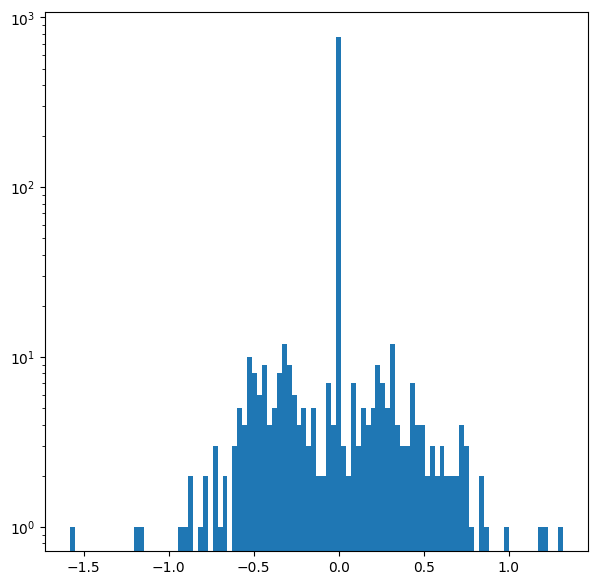

In [7]:
w = model.layers[0].weights[0].numpy()
h, b = np.histogram(w, bins=100)
plt.figure(figsize=(7, 7))
plt.bar(b[:-1], h, width=b[1] - b[0])
plt.semilogy()
print('% of zeros = {}'.format(np.sum(w == 0) / np.size(w)))

## Check performance
How does this 75% sparse model compare against the unpruned model? Let's report the accuracy and make a ROC curve. The pruned model is shown with solid lines, the unpruned model from part 1 is shown with dashed lines.
**Make sure you've trained the model from part 1**

Accuracy unpruned: 0.7640722891566265
Accuracy pruned:   0.7563493975903615


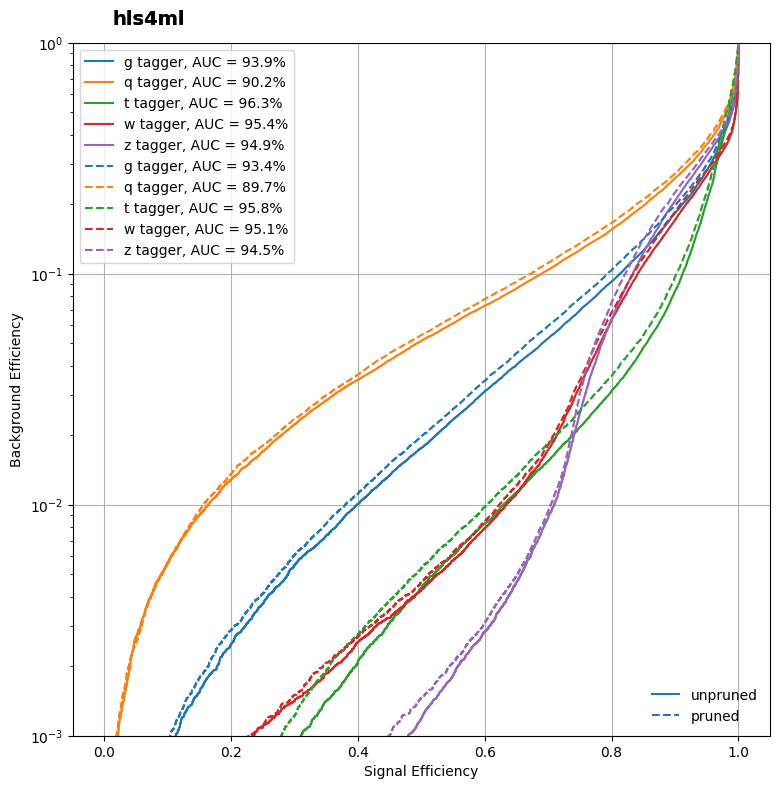

In [14]:
import plotting_pre
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

model_ref = load_model('baseline_jet_tagging_model/KERAS_check_best_model.h5')

# y_ref = model_ref.predict(X_test)
# y_prune = model.predict(X_test)

print("Accuracy unpruned: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
print("Accuracy pruned:   {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_prune, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting_pre.makeRoc(y_test, y_ref, classes)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting_pre.makeRoc(y_test, y_prune, classes, linestyle='--')

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['unpruned', 'pruned'], loc='lower right', frameon=False)
ax.add_artist(leg)

## Convert the model to FPGA firmware with hls4ml
Let's use the default configuration: `ap_fixed<16,6>` precision everywhere and `ReuseFactor=1`, so we can compare with the part 1 model. We need to use `strip_pruning` to change the layer types back to their originals.

**The synthesis will take a while**

While the C-Synthesis is running, we can monitor the progress looking at the log file by opening a terminal from the notebook home, and executing:

`tail -f model_2/hls4ml_prj/vitis_hls.log`

In [9]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(model, granularity='model', backend='Vivado')
print(config)
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, backend='Vivado', output_dir='pruned_jet_tagging_model/hls4ml_prj', part='xc7z020clg400-1'
)
hls_model.compile()
hls_model.build(synth=True)

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
{'Model': {'Precision': {'default': 'fixed<16,6>'}, 'ReuseFactor': 1, 'Strategy': 'Latency', 'BramFactor': 1000000000, 'TraceOu

{'CSimResults': [['0.0537109', '0.15625', '0.400391', '0.242188', '0.176758'],
  ['0.0537109', '0.15625', '0.400391', '0.242188', '0.176758'],
  ['0.0537109', '0.15625', '0.400391', '0.242188', '0.176758'],
  ['0.0537109', '0.15625', '0.400391', '0.242188', '0.176758'],
  ['0.0537109', '0.15625', '0.400391', '0.242188', '0.176758']],
 'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '4.362',
  'BestLatency': '42',
  'WorstLatency': '42',
  'IntervalMin': '1',
  'IntervalMax': '1',
  'BRAM_18K': '4',
  'DSP': '922',
  'FF': '101750',
  'LUT': '30926',
  'URAM': '0',
  'AvailableBRAM_18K': '280',
  'AvailableDSP': '220',
  'AvailableFF': '106400',
  'AvailableLUT': '53200',
  'AvailableURAM': '0'}}

## Check the reports
Print out the reports generated by Vitis HLS. Pay attention to the Utilization Estimates' section in particular this time.

In [10]:
hls4ml.report.read_vivado_report('pruned_jet_tagging_model/hls4ml_prj/')

Found 1 solution(s) in pruned_jet_tagging_model/hls4ml_prj//myproject_prj.
Reports for solution "solution1":

C SIMULATION RESULT:
INFO: [SIM 2] *************** CSIM start ***************
INFO: [SIM 4] CSIM will launch GCC as the compiler.
   Compiling ../../../../myproject_test.cpp in debug mode
   Compiling ../../../../firmware/myproject.cpp in debug mode
   Generating csim.exe
INFO: Unable to open input/predictions file, using default input.
0.0537109 0.15625 0.400391 0.242188 0.176758 
0.0537109 0.15625 0.400391 0.242188 0.176758 
0.0537109 0.15625 0.400391 0.242188 0.176758 
0.0537109 0.15625 0.400391 0.242188 0.176758 
0.0537109 0.15625 0.400391 0.242188 0.176758 
INFO: Saved inference results to file: tb_data/csim_results.log
INFO: [SIM 1] CSim done with 0 errors.
INFO: [SIM 3] *************** CSIM finish ***************

SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Wed Jun  4 15:05:52 2025

* Version:        2020.1 (Build 2897737 on Wed May 27 20:21:

Print the report for the model trained in part 1. Remember these models have the same architecture, but the model in this section was trained using the sparsity API from tensorflow_model_optimization. Notice how the resource usage had dramatically reduced (particularly the DSPs). When Vitis HLS notices an operation like `y = 0 * x` it can avoid placing a DSP for that operation. The impact of this is biggest when `ReuseFactor = 1`, but still applies at higher reuse as well. **Note you need to have trained and synthesized the model from part 1**

In [11]:
hls4ml.report.read_vivado_report('baseline_jet_tagging_model/hls4ml_prj')

Found 1 solution(s) in baseline_jet_tagging_model/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C SIMULATION RESULT:
INFO: [SIM 2] *************** CSIM start ***************
INFO: [SIM 4] CSIM will launch GCC as the compiler.
   Compiling ../../../../myproject_test.cpp in debug mode
   Compiling ../../../../firmware/myproject.cpp in debug mode
   Generating csim.exe
INFO: Unable to open input/predictions file, using default input.
0.0332031 0.103516 0.282227 0.234375 0.363281 
0.0332031 0.103516 0.282227 0.234375 0.363281 
0.0332031 0.103516 0.282227 0.234375 0.363281 
0.0332031 0.103516 0.282227 0.234375 0.363281 
0.0332031 0.103516 0.282227 0.234375 0.363281 
INFO: Saved inference results to file: tb_data/csim_results.log
INFO: [SIM 1] CSim done with 0 errors.
INFO: [SIM 3] *************** CSIM finish ***************

SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Wed Jun  4 14:57:23 2025

* Version:        2020.1 (Build 2897737 on Wed May 27 